In [1]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numba import jit
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize, root_scalar
from pynndescent import NNDescent
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA

In [2]:
@jit(cache=False)
def entropy(d, beta):
    # remove 'cache=False' (only for testing)
    x = - d * beta
    y = np.exp(x)
    ysum = y.sum()
    if ysum < 1e-50:
        return -1.
    else:
        factor = - 1/(np.log(2.) * ysum)
        return factor * ((y * x) - (y * np.log(ysum))).sum()

In [3]:
def p_i(d, beta):
    x = - d * beta
    y = np.exp(x)
    ysum = y.sum()
    return y / ysum

In [4]:
def find_beta(d, perp, upper_bound=1e6):
    return root_scalar(
        lambda b: entropy(d, b) - np.log2(perp),
        bracket=(0.,upper_bound)
    ).root

In [5]:
def p_ij_sym(x, perp, verbose=False):
    num_pts = x.shape[0]
    k = min(num_pts - 1, int(3 * perp))
    if verbose:
        print('Indexing')
    index = NNDescent(x)
    neighbors = np.empty((num_pts, k-1), dtype=np.int)
    p_ij = np.empty((num_pts, k-1))
    for i, xi in enumerate(x):
        if verbose:
            print('Calculating probabilities: {cur}/{tot}'.format(
                cur=i+1, tot=num_pts), end='\r')
        nn, dists = index.query([xi], k)
        beta = find_beta(dists[0, 1:], perp)
        neighbors[i] = nn[0, 1:]
        p_ij[i] = p_i(dists[0, 1:], beta)
    row_indices = np.repeat(np.arange(num_pts), k-1)
    p = csr_matrix((p_ij.ravel(), (row_indices, neighbors.ravel())))
    return 0.5*(p + p.transpose())

In [6]:
def dist_mat_squared(x):
    batch_size = x.shape[0] 
    expanded = x.unsqueeze(1)
    tiled = torch.repeat_interleave(expanded, batch_size, dim=1)
    diffs = tiled - tiled.transpose(0, 1)
    sum_act = torch.sum(torch.pow(diffs,2), axis=2)    
    return sum_act

In [7]:
def norm_sym(x):
    x.fill_diagonal_(0.)
    norm_facs = x.sum(axis=0, keepdim=True)
    x = x / norm_facs
    return 0.5*(x + x.t())

In [8]:
def q_ij(x, alpha):
    dists = dist_mat_squared(x)
    q = torch.pow((1 + dists/alpha), -(alpha+1)/2)
    return norm_sym(q)

In [9]:
def kullback_leibler_loss(p, q, eps=1.0e-7):
    eps = torch.tensor(eps, dtype=p.dtype)
    kl_matr = torch.mul(p, torch.log(p + eps) - torch.log(q + eps))
    kl_matr.fill_diagonal_(0.)    
    return torch.sum(kl_matr)

In [10]:
def kullback_leibler_reverse_loss(p, q, eps=1.0e-7):
    return kl_loss(q, p)

In [11]:
def jensen_shannon_loss(p, q, eps=1.0e-7):
    m = 0.5*(p+q)
    return 0.5*kl_loss(p, m) + 0.5*kl_loss(q, m)

In [12]:
def frobenius_loss(p, q):
    return torch.pow(p - q, 2).sum()

In [68]:
def bhattacharyya_loss(p, q):
    return 1 - torch.sqrt(p * q).sum()

In [13]:
def total_variational_loss(p, q):
    return torch.abs(p-q).sum()

In [14]:
def submatrix(m, indices):
    dim = len(indices)
    indices = np.array(np.meshgrid(indices, indices)).T.reshape(-1,2).T
    return torch.tensor(m[indices[0], indices[1]].reshape(dim, dim))

In [81]:
class Parametric_tSNE(nn.Module):
    
    def __init__(self, input_dim, output_dim, perp,
                 alpha=1.0,
                 hidden_layer_dims=None,
                 seed=None,
                 use_cuda=False):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.perplexity = perp
        self.alpha = alpha
        
        self.use_cuda = use_cuda
        
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        # If no layers provided, use the same architecture as van der maaten 2009 paper
        if hidden_layer_dims is None:
            hidden_layer_dims = [500, 500, 2000]
        
        self.layers = nn.ModuleList()
        
        cur_dim = input_dim
        for hdim in hidden_layer_dims:
            self.layers.append(nn.Linear(cur_dim, hdim))
            cur_dim = hdim
        self.layers.append(nn.Linear(cur_dim, output_dim))
        
        if self.alpha == 'learn':
            self.alpha = nn.Parameter(torch.tensor(1.))
        
        if self.use_cuda:
            self.cuda()
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            # x = torch.sigmoid(layer(x))
            x = F.softplus(layer(x))
        out = self.layers[-1](x)
        return out
    
    def pretrain(self, training_data,
            epochs=10,
            verbose=False,
            batch_size=500,
            learning_rate=0.01):
        if verbose:
            print('Calculating PCA')
        pca = torch.tensor(PCA(n_components=2).fit_transform(training_data), dtype=training_data.dtype)
        
        dataset = torch.utils.data.TensorDataset(training_data, pca)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        
        if verbose:
            print('{time}: Beginning pretraining for {epochs} epochs'.format(
                time=datetime.datetime.now(),
                epochs=epochs))
        
        for epoch in range(epochs):
            running_loss = 0
            for batch, data in enumerate(dataloader):
                
                features, targets = data
                    
                if self.use_cuda:
                    features = features.cuda()
                    targets = targets.cuda()
                    
                optim.zero_grad()
                
                loss = criterion(self(features), targets)
                
                loss.backward()
                optim.step()
                    
                running_loss += loss.item()
                
            if verbose:
                print('{time}: Loss after epoch {ep}: {rloss}'.format(
                    time=datetime.datetime.now(),
                    ep=epoch,
                    rloss=running_loss))

        if verbose:
            print('{time}: Finished pretraining'.format(
                time=datetime.datetime.now()))
        
    def fit(self, training_data,
            loss_func='kl',
            p_ij=None,
            pretrain=False,
            epochs=10,
            verbose=False,
            optimizer=torch.optim.Adam,
            batch_size=500,
            learning_rate=0.01):
        
        assert training_data.shape[1] == self.input_dim, "Input training data must be same shape as training `num_inputs`"
        
        self.p_ij = p_ij
        self._epochs = epochs
        
        if pretrain:
            self.pretrain(training_data, epochs=5, verbose=verbose, batch_size=batch_size)
        
        if self.p_ij is None:
            self.p_ij = p_ij_sym(training_data.numpy(), self.perplexity, verbose=verbose).toarray()
            
        dataset = torch.utils.data.TensorDataset(training_data, torch.arange(training_data.shape[0]))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optim = optimizer(self.parameters(), lr=learning_rate)
        
        if verbose:
            print('{time}: Beginning training for {epochs} epochs'.format(
                time=datetime.datetime.now(),
                epochs=epochs))
            
        loss_func = {
            'kl': kullback_leibler_loss,
            'kl_rev': kullback_leibler_reverse_loss,
            'js': jensen_shannon_loss,
            'frob': frobenius_loss,
            # 'bat': bhattacharyya_loss,
            'tot': total_variational_loss
        }[loss_func]
        
        for epoch in range(epochs):
            running_loss = 0
            for batch, data in enumerate(dataloader):
                
                features, indices = data
                
                p = submatrix(self.p_ij, indices.numpy())
                p = p / p.sum()
                
                if epoch < 10:
                    # exaggeration test
                    exaggeration = 10.
                    p *= exaggeration
                    
                if self.use_cuda:
                    features = features.cuda()
                    p = p.cuda()
                    
                optim.zero_grad()
                
                q = q_ij(self(features), self.alpha)
                q = q / q.sum()
                
                loss = loss_func(p, q)
                
                if epoch < 10:
                   # exaggeration tets
                   loss = loss / exaggeration - np.log(exaggeration)
                
                loss.backward()
                optim.step()
                    
                running_loss += loss.item()
                
            if verbose:
                print('{time}: Loss after epoch {ep}: {rloss}'.format(
                    time=datetime.datetime.now(),
                    ep=epoch+1,
                    rloss=running_loss))

        if verbose:
            print('{time}: Finished training'.format(
                time=datetime.datetime.now()))

In [16]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [17]:
mnist = MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

In [18]:
testdata = mnist.data.reshape(-1, 28*28) / 255.

Notes from testing:

- `hidden_layer_dims = [300,100]` works well
- learned `alpha` for perplexity of 100 is about 1.8
- learned `alpha` for perplexity of 50 is > 2

In [82]:
foo = Parametric_tSNE(28*28, 2, 50, use_cuda=True, hidden_layer_dims=[300,100], alpha=1)

In [86]:
foo.fit(testdata[:20000], batch_size=1000, epochs=30, learning_rate=0.01, pretrain=True, verbose=True, loss_func='kl')

Calculating PCA
2019-12-18 12:22:46.144297: Beginning pretraining for 5 epochs
2019-12-18 12:22:46.477405: Loss after epoch 0: 1712.291337966919
2019-12-18 12:22:46.776144: Loss after epoch 1: 65.6235865354538
2019-12-18 12:22:47.131585: Loss after epoch 2: 22.15089923143387
2019-12-18 12:22:47.429788: Loss after epoch 3: 8.769697725772858
2019-12-18 12:22:47.727991: Loss after epoch 4: 4.790023222565651
2019-12-18 12:22:47.727991: Finished pretraining
Indexing
2019-12-18 12:24:20.874562: Beginning training for 30 epochs
2019-12-18 12:24:22.878202: Loss after epoch 1: 77.27479387116608
2019-12-18 12:24:24.790104: Loss after epoch 2: 69.29574283380857
2019-12-18 12:24:26.603254: Loss after epoch 3: 66.02591579692664
2019-12-18 12:24:28.467285: Loss after epoch 4: 64.1188614339003
2019-12-18 12:24:30.409107: Loss after epoch 5: 63.422239955135225
2019-12-18 12:24:32.277350: Loss after epoch 6: 62.276835409370634
2019-12-18 12:24:34.218665: Loss after epoch 7: 61.829992533080514
2019-12-1

In [23]:
p_precalc = foo.p_ij

In [87]:
bar = foo(testdata[:20000].cuda()).cpu().detach().numpy()

In [53]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

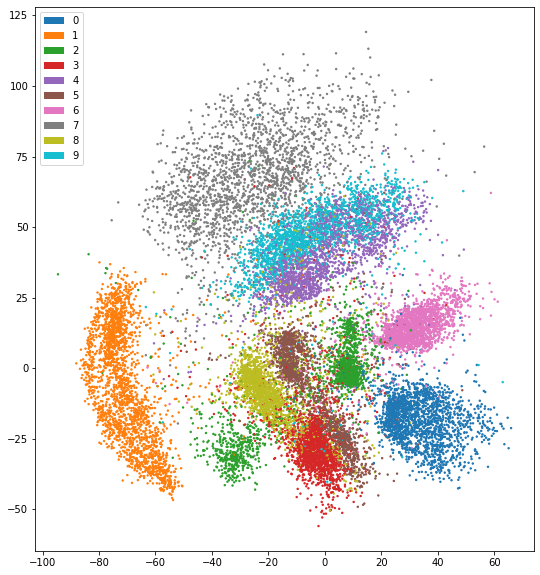

In [89]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist.targets[:20000]]
ax.scatter(bar[:,0],bar[:,1],c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [8]:
foo = TSNE(perplexity=50).fit(testdata[:10000])

D:\Dokumente\Dissertation\Code\python\ptsne-pytorch\env\lib\site-packages\openTSNE\nearest_neighbors.py:184: UserWarning: `pynndescent` has recently changed which distance metrics are supported, and `openTSNE.nearest_neighbors` has not been updated. Please notify the developers of this change.
  "`pynndescent` has recently changed which distance metrics are supported, "
D:\Dokumente\Dissertation\Code\python\ptsne-pytorch\env\lib\site-packages\numba\ir_utils.py:1969: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'forest' of function 'initialise_search'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "env\lib\site-packages\pynndescent\pynndescent_.py", line 72:
@numba.njit()
def initialise_search(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


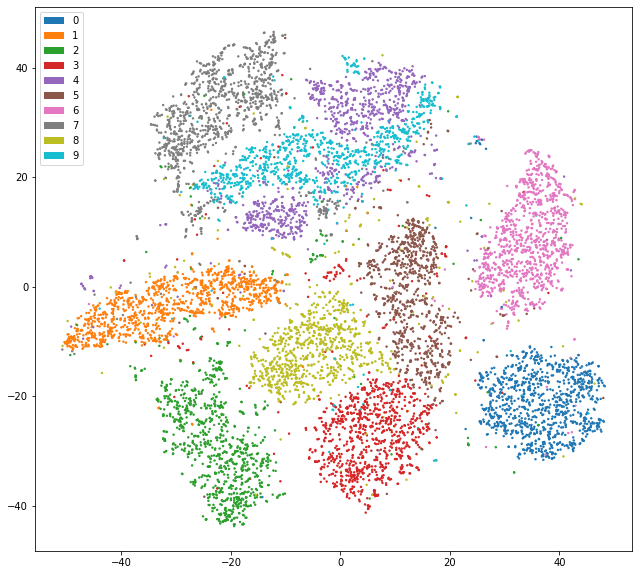

In [12]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist.targets[:10000]]
ax.scatter(foo[:,0],foo[:,1],c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)